# Data Science Pipeline

While presented in a linear fashion, the workflow is very much iterative.

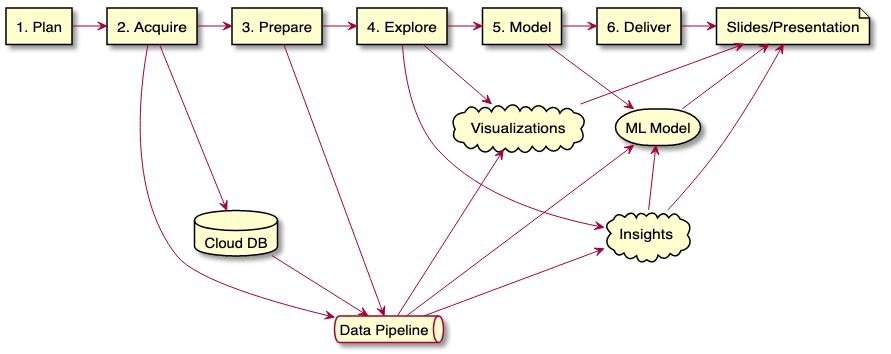

# MVP Demo

## Setup

In [1]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
plt.rc('font', size=16)

## Data Wrangling

In [3]:
# Data from https://archive-beta.ics.uci.edu/ml/datasets/real+estate+valuation+data+set
df = pd.read_excel('real_estate_valuation.xlsx')
df = df.set_index('No')
df.columns = ['transaction_date', 'house_age', 'distance_to_mrt', 'n_stores', 'latitude', 'longitude', 'price_per_area']
print('shape', df.shape)

shape (414, 7)


In [4]:
df.isna().sum()

transaction_date    0
house_age           0
distance_to_mrt     0
n_stores            0
latitude            0
longitude           0
price_per_area      0
dtype: int64

No nulls, yay!

In [5]:
# These features look easiest to deal with at first
df = df[['house_age', 'distance_to_mrt', 'n_stores', 'price_per_area']]
df.head()

,house_age,distance_to_mrt,n_stores,price_per_area
No,,,,
1,32.0,84.87882,10,37.9
2,19.5,306.59470,9,42.2
3,13.3,561.98450,5,47.3
4,13.3,561.98450,5,54.8
5,5.0,390.56840,5,43.1


Features:

- **house_age**: age of house in years
- **distance_to_mrt**: distance (im m) to closest mrt station (public transportation)
- **n_stores**: number of stores in the walkable area
- **price_per_area**: 10k new tawain dollar / ping, 1 ping = 3.3 m^2

In [6]:
train_and_validate, test = train_test_split(df, random_state=123, test_size=.2)
train, validate = train_test_split(train_and_validate, random_state=123, test_size=.2)

## Explore

Initial thoughts:

- drivers of price might be house age (-), distance to mrt station (-), n_stores(+)
- age and distance to mrt might be negatively correlated
- distance to mrt and n stores might be positively correlated
- some cutoff for n_stores might be useful

In [7]:
train.head()

,house_age,distance_to_mrt,n_stores,price_per_area
No,,,,
345,34.6,3085.1700,0,41.2
160,15.5,815.9314,4,37.4
381,14.1,289.3248,5,53.3
15,13.2,1164.8380,4,34.3
75,6.8,379.5575,10,54.4


### Which features are correlated?

In [8]:
train.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,house_age,distance_to_mrt,n_stores,price_per_area
house_age,1.000000,0.068082,0.032940,-0.225460
distance_to_mrt,0.068082,1.000000,-0.585638,-0.664288
n_stores,0.032940,-0.585638,1.000000,0.508189
price_per_area,-0.225460,-0.664288,0.508189,1.000000


- distance to mrt has the strongest (negative!) relationship with price
- no relationship between house age and n_stores, distance to mrt
- slight negative relationship between house age and price
- n_stores and price are positively correlated
- distance to mrt and n_stores are positively correlated
- house age doesn't seem to correlate with anything

### What's the relationship between house age and price?

Text(25, 120, 'r = -0.2255, p = 0.0002')

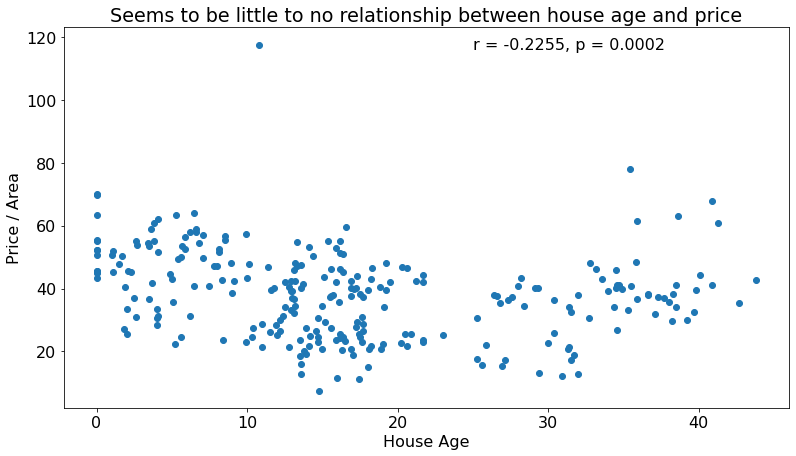

In [9]:
fig, ax = plt.subplots(figsize=(13, 7))

r, p = stats.pearsonr(train.house_age, train.price_per_area)

ax.scatter(train.house_age, train.price_per_area)
ax.set(
    xlabel='House Age',
    ylabel='Price / Area',
    title='Seems to be little to no relationship between house age and price',
)
text = f'r = {r:.4f}, p = {p:.4f}'
ax.text(25, 120, text, va='top', ha='left')

Seems like there are two groups, houses < 25 years and > 25 years. The nature of the price <> age relationship might be stronger within the subgroups.



### Can we find a cutoff for n_stores that is meaningful?

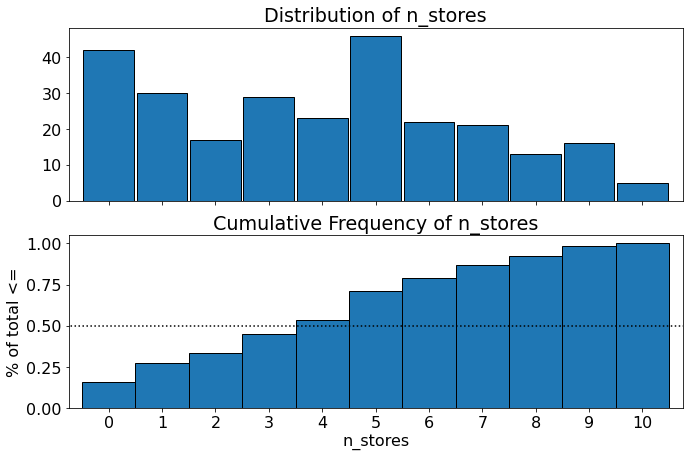

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

train.n_stores.value_counts().sort_index().plot.bar(
    ax=ax1, width=.95, ec='black', title='Distribution of n_stores'
)

train.n_stores.value_counts(normalize=True).sort_index().cumsum().plot.bar(
    width=1, ec='black', title='Cumulative Frequency of n_stores', xlabel='n_stores', ylabel='% of total <=', ax=ax2
)
ax2.tick_params(axis='x', labelrotation=0)
ax2.axhline(.5, *ax2.get_xlim(), color='black', ls=':')

In [11]:
'{:.1%} of houses have 4 or more stores in the area'.format((train.n_stores > 4).mean())

'46.6% of houses have 4 or more stores in the area'

In [12]:
# add the feature
train = train.assign(high_store_density=train.n_stores > 4)
validate = validate.assign(high_store_density=validate.n_stores > 4)
test = test.assign(high_store_density=test.n_stores > 4)

Questions for further exploration:

- Controlling for store density, do the previously observed relationships hold?
- Can we find similar cutoffs for other features? Distance to mrt might be a good one to bin and use bins to viz
- Investigate correlations controlling for house age.

## Modeling

In [13]:
predictions = pd.DataFrame()
predictions['actual'] = validate.price_per_area
predictions['baseline'] = train.price_per_area.median()

A simple linear model with the most correlated feature can provide an "advanced" baseline

In [14]:
X_train = train[['distance_to_mrt']]
X_validate = validate[['distance_to_mrt']]
y_train = train.price_per_area

model = LinearRegression()
model.fit(X_train, y_train)
predictions['simple lm'] = model.predict(X_validate)
model.score(X_train, y_train)

0.4412789561202135

In [15]:
m, b = model.coef_[0], model.intercept_
print(f'price = {m:.4f} x distance_to_mrt + {b:.4f}')

price = -0.0071 x distance_to_mrt + 46.1557


Interpretation: per the simple linear regression model, price goes down by 7.1 every kilometer closer to an mrt station we get.

Multiple regression w/ all features (we're only looking at 3), but we'll use our engineered feature instead of n_stores

In [16]:
X_train = train[['distance_to_mrt', 'house_age', 'high_store_density']]
X_validate = validate[['distance_to_mrt', 'house_age', 'high_store_density']]
y_train = train.price_per_area

model = LinearRegression()
model.fit(X_train, y_train)
predictions['multiple regr'] = model.predict(X_validate)
model.score(X_train, y_train)

0.5085535826002023

In [17]:
pd.Series(model.coef_, index=X_train.columns)

distance_to_mrt      -0.005593
house_age            -0.229871
high_store_density    6.289483
dtype: float64

- price goes down by 5.5 every kilometer closer to an mrt station we get
- price_per_are goes up by ~ 1 every 5 years newer the house is
- everything else being equal, being in a high store density area raises the price by 6.3

K-neighbors regressor

In [18]:
X_train = train[['distance_to_mrt', 'house_age', 'high_store_density']]
X_validate = validate[['distance_to_mrt', 'house_age', 'high_store_density']]
y_train = train.price_per_area

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train_scaled, y_train)
predictions['k-neighbors (k=3)'] = model.predict(X_validate_scaled)
model.score(X_train_scaled, y_train)

0.7877969378816132

Big fancy complicated model

1. create polynomial interaction features
1. scale
1. RFE
1. model

In [19]:
X_train = train[['distance_to_mrt', 'house_age', 'n_stores']]
X_validate = validate[['distance_to_mrt', 'house_age', 'n_stores']]
y_train = train.price_per_area

scaler = MinMaxScaler()
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
model = LinearRegression()
rfe = RFE(model, n_features_to_select=4)

poly.fit(X_train)
X_train_poly = poly.transform(X_train)

scaler.fit(X_train_poly)
X_train_scaled = scaler.transform(X_train_poly)

rfe.fit(X_train_scaled, y_train)
X_train_rfe = rfe.transform(X_train_scaled)

model.fit(X_train_rfe, y_train)

X_validate_rfe = rfe.transform(scaler.transform(poly.transform(X_validate)))
predictions['big fancy'] = model.predict(X_validate_rfe)

model.score(X_train_rfe, y_train)

0.5760553099964358

In [20]:
pd.concat([
    predictions.apply(lambda col: r2_score(predictions.actual, col)).rename('r2'),
    predictions.apply(lambda col: mean_squared_error(predictions.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)

,r2,mse,rmse
actual,1.000000,0.000000,0.000000
baseline,-0.013233,165.491194,12.864338
simple lm,0.343457,107.233114,10.355342
multiple regr,0.513998,79.378578,8.909466
k-neighbors (k=3),0.484719,84.160829,9.173921
big fancy,0.531116,76.582697,8.751154


Modeling next steps:

- minmax scaler to range (0, 2) (or diff) for better interpretation
- try out other values for k
- interpret the big fancy model (esp if its our best)
- visualize residuals

Other things to do:

- modularize notebook code, i.e. put it in .py modules
- explore additional features